<h2 align=center> <b><u> Fine-Tuned BERT for Sentiment Analysis on the Sentiment140 Dataset </u></b>
</h2>

### 1. Check GPU Availability and install dependencies

In [1]:
!nvidia-smi

Thu Mar  7 13:57:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.


# After running this cell, we have to restart the Kernel and after restarting run this cell once again!

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


2024-03-07 13:57:29.179427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 13:57:29.179534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 13:57:29.304657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Import the Quora Insincere Questions Dataset

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                 names = col_names,
                 encoding = "ISO-8859-1")
df.shape

(1600000, 6)

In [6]:
df.tail(20)

,target,id,date,flag,user,text
1599980,4,2193578679,Tue Jun 16 08:38:56 PDT 2009,NO_QUERY,puchal_ek,@myheartandmind jo jen by nemuselo zrovna tÃ© ...
1599981,4,2193578716,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,youtubelatest,Another Commenting Contest! [;: Yay!!! http:/...
1599982,4,2193578739,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,Mandi_Davenport,@thrillmesoon i figured out how to see my twee...
1599983,4,2193578758,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,xoAurixo,"@oxhot theri tomorrow, drinking coffee, talkin..."
1599984,4,2193578847,Tue Jun 16 08:38:57 PDT 2009,NO_QUERY,RobFoxKerr,You heard it here first -- We're having a girl...
1599985,4,2193578982,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,LISKFEST,"if ur the lead singer in a band, beware fallin..."
1599986,4,2193579087,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,marhgil,@tarayqueen too much ads on my blog.
1599987,4,2193579092,Tue Jun 16 08:38:58 PDT 2009,NO_QUERY,cathriiin,@La_r_a NEVEER I think that you both will get...
1599988,4,2193579191,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,tellman,@Roy_Everitt ha- good job. that's right - we g...
1599989,4,2193579211,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,jazzstixx,@Ms_Hip_Hop im glad ur doing well


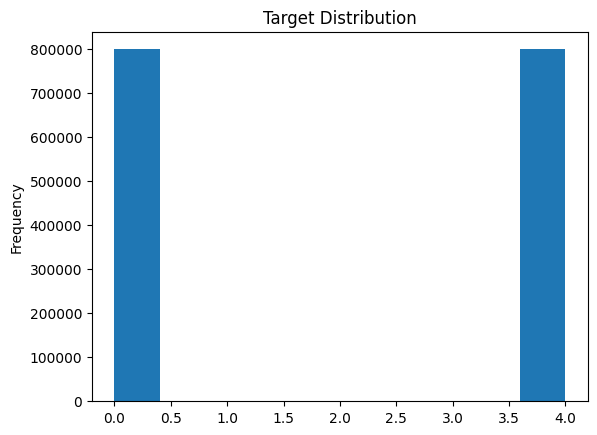

In [7]:
df.target.plot(kind='hist', title = 'Target Distribution');

In [8]:
# renaming the labels as 0 and 1 instead of 0 and 4

df.replace({'target':{4:1}}, inplace = True)

### 0 --> Negative Tweet, 1 --> Positive Tweet

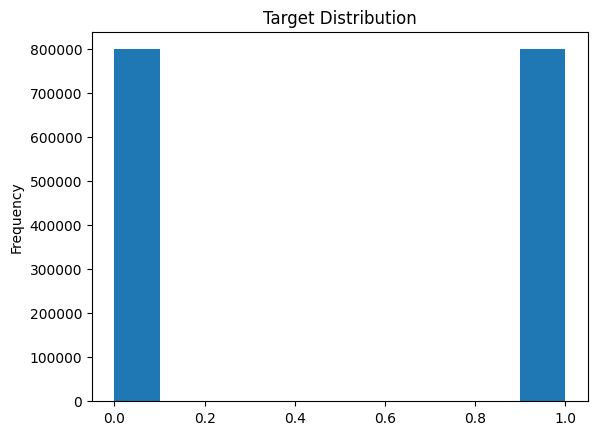

In [9]:
df.target.plot(kind='hist', title = 'Target Distribution');

### 3. Preparing Input Data for Training and Evaluation

Since BERT is a pretrained model, it is sufficient to train it on a small subset of the original dataset. Else, training the entire dataset on BERT would take nearly 7 hours to complete!!! 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Splitting the dataset into train and valid (90% and 10% respectively)
train_df, test_df = train_test_split(df, random_state=42, train_size=0.1, test_size = 0.01, stratify=df.target.values)

In [11]:
X_train = train_df["text"]
y_train = train_df["target"]

X_test = test_df["text"]
y_test = test_df["target"]

In [12]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(160000,)
(160000,)
(16000,)
(16000,)


### 4. Input Format for BERT

**Token IDs** - This corresponds to the tokenized strings padded with 0s
                upto the max sequence length and beginning with CLS and ending with SEP. <br><br>
**Input Mask** - Note that BERT uses Self-Attention Networks to provide
                 contextualised embeddings corresponding to each token in the token string i.e., for each word in the string BERT looks to the left and right of it in the sentence so as to find contextual meaning of the word in the sentence (say, if there is a "the", then look at the noun to which it points). Now, note that we have padded our token strings with 0s upto the max seq length, but we do not want the padding 0s to influence the contextual information to be derived.  The Input Mask is a list of same length as the length of Token Ids (ie the max seq length) where there is a 0 for a padding and 1 for a valid token. The 0s will cancel out the internal multiplications that we perform for capturing the Self Attention for contextual information. <br><br>

**Input Type IDs** - Note that originally BERT was pretrained on two   tasks, Masked Language Modelling (where random words from the sentence would be masked and it would be the task for the BERT to predict what those masked words are) and the other task was Next Sentence Prediction or NSP (Given two sentences, the BERT has to predict which came first and which came after. The first sentence was given the value 0 and the next sentence was given the value 1).<br><br>
**In Text classification, we are dealing with only 1 sequence at a time, so our input type IDs would just be a vector with all values 0. **


### 5. Checking the tokenization process

In [13]:
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")

# Tokenize the input text
input_text = ["Hello, how are you?"]
tokenized_output = preprocessor(input_text)

# Print token IDs
print(tokenized_output['input_word_ids'])
print(tokenized_output['input_mask'])
print(tokenized_output['input_type_ids'])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...


tf.Tensor(
[[ 101 7592 1010 2129 2024 2017 1029  102    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dty

Upon checking the input word ids, we find that the tokens are --> "Hello", "#,", "how", "are", "you" and "#?" {'#' signifies that the succeeding character ',' is attached to characters before] and they are encoded as [7592 1010 2129 2024 2017 1029]. 

Note that this is not the whole story. We also have to make sure that each sequence is initiated with the CLS token (which signifies start of sequence and has a token_id 101) and ended with SEP (separator) which means end of sequence and has a token_id 102. Also we have to make sure that all tensors have sequence size equal to the max_sequence_length by using padding.

### 6. Add a Classification Head to the BERT Layer

We only need the pooled_output that represents the whole sentence (using the CLS token that contains the contextual information of the whole sentence) and not the sequence_output.

In [14]:
# Building the model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].





# Classification
# Add dropout layer
drop1 = tf.keras.layers.Dropout(0.2)(pooled_output)

# Add hidden dense layers
hidden1 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(0.2)(hidden2)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop3)


model=tf.keras.Model(inputs=[text_input],outputs=[output_layer])

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2' to your Kaggle notebook...


### 7. Fine-Tune BERT for Text Classification

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [16]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_binary_accuracy',  # Quantity to be monitored
        save_weights_only=True,  # Do not save the entire model
        verbose=1,  # Verbosity mode. 0 or 1.
        save_freq='epoch'  # Save the model at the end of every epoch
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        monitor='val_binary_accuracy',  # Quantity to be monitored
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_binary_accuracy',  # Quantity to be monitored
        factor=0.5,  # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-7  # Lower bound on the learning rate
    )
]

In [ ]:
# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [ ]:
#!rm "/kaggle/working/model.png"

In [19]:
# Train model
epochs = 2
history = model.fit(X_train, 
                    y_train,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks
                   )

Epoch 1/2


I0000 00:00:1709819916.482601     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 2581s 508ms/step - loss: 0.3964 - binary_accuracy: 0.8247 - lr: 2.0000e-05
Epoch 2/2
5000/5000 [==============================] - 2538s 508ms/step - loss: 0.3094 - binary_accuracy: 0.8695 - lr: 2.0000e-05


### 8. Evaluate the BERT Text Classification Model

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    #plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    #plt.legend([metric, 'val_'+metric])
    plt.legend([metric])
    plt.show()

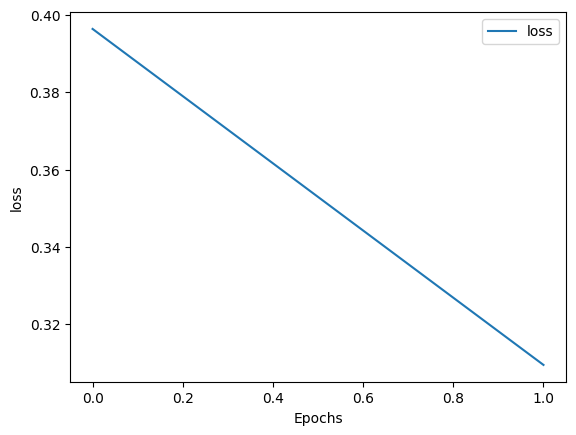

In [21]:
plot_graphs(history, 'loss')

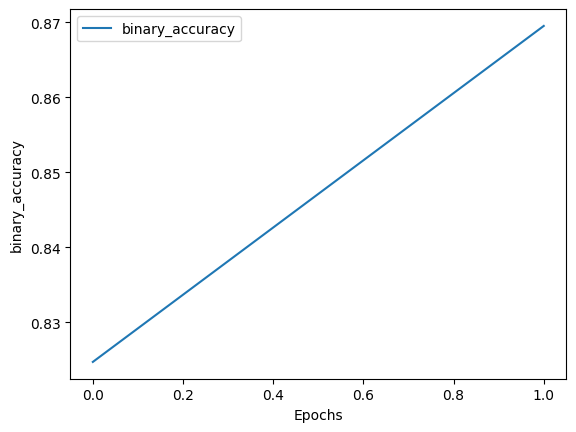

In [22]:
plot_graphs(history, 'binary_accuracy')

### 9. Sanity Checking

In [23]:
sample_example = ["why are americans racist?", "why are indians so black?", "have a great day!"]
preds = model.predict(sample_example)
threshold = 0.5 #between 0 and 1


["Positive Tweet" if pred>=threshold else "Negative Tweet" for pred in preds]

1/1 [==============================] - 1s 804ms/step


['Negative Tweet', 'Negative Tweet', 'Positive Tweet']

### 10. Trying the Trained BERT Model on Test Data

In [24]:
print(X_test.shape)
print(y_test.shape)

(16000,)
(16000,)


In [ ]:
y_predict=model.predict(X_test)

In [ ]:
y_predict.shape

In [ ]:
threshold = 0.5
preds = [1 if pred[0]>=threshold else 0 for pred in y_predict]

### 11. Performance on Test Data

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)

print("Binary Accuracy on Test Data:", round(accuracy*100, 3))